### Install the below requirements for running the notebook

In [ ]:
!pip install lightly                         # for SimCLR
!pip install byol-pytorch                    # for BYOL
!git clone https://github.com/facebookresearch/moco.git
!pip install -r moco/requirements.txt        # for MoCo
!git clone https://github.com/facebookresearch/dino.git

In [ ]:
import os
import json
import torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
from torchvision.datasets import ImageFolder
import torch
import glob
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.amp import GradScaler
import random
from sklearn.manifold import TSNE
from torchvision.models import resnet18
from lightly.models.modules import SimCLRProjectionHead
from moco.moco.builder import MoCo
from byol_pytorch import BYOL
import torch
from torch.utils.data import random_split, DataLoader
import torch.distributed as dist
import re
import torch
from vision_transformer import vit_small  , DINOHead     
from utils import MultiCropWrapper 
from main_dino import DINOLoss               
from torch.optim import AdamW

torch.backends.cudnn.benchmark = True
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

os.environ["MASTER_ADDR"] = "127.0.0.1"
os.environ["MASTER_PORT"] = "29500"

dist.init_process_group(backend="gloo", rank=0, world_size=1)

In [2]:
print("CUDA available?", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)
print("Device:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device, torch.cuda.get_device_name(0) if device.type=="cuda" else "")

CUDA available? True
Torch CUDA version: 12.4
Device: NVIDIA A100-SXM4-40GB
Training on: cuda NVIDIA A100-SXM4-40GB


In [105]:
# Define dataset paths
unlabeled_path = "data/unlabeled_data"
labeled_path = "data/labeled_data"

In [ ]:
# define transforms for labelled dataset
tf = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor()])

labelled_dataset = ImageFolder(root=labeled_path, transform=tf)
print(f"Found {len(labelled_dataset)}")
num_classes = len(labelled_dataset.classes)
print(f"Labelled dataset has images across {num_classes}")

# define split for train, test, val among labelled dataset

dataset_size = len(labelled_dataset)
val_size = int(0.1 * dataset_size)
test_size = int(0.1 * dataset_size)
train_size = dataset_size - val_size - test_size

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(labelled_dataset,[train_size, val_size, test_size],generator=generator)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=8)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=8)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=8)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Test samples: {len(test_ds)}")

Found 15158
Labelled dataset has images across 43
Train samples: 12128, Val samples: 1515, Test samples: 1515


In [ ]:
# contrastive‐learning augmentation pipeline that produces two different “views” of each image
# this is done to create invariance among input images for ssl models
ssl_transform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),  transforms.RandomHorizontalFlip(p=0.5),transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),transforms.ToTensor(),])


class TwoViewDataset(Dataset):
    def __init__(self, image_folder, transform):
        self.paths = glob.glob(f"{image_folder}/*.jpg") + glob.glob("data/unlabeled_data/*.png")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        # generate two random views
        view1 = self.transform(img)
        view2 = self.transform(img)
        return view1, view2

unlabelled_dataset = TwoViewDataset(unlabeled_path, ssl_transform)

print(f"Found {len(unlabelled_dataset)}")
unlablled_loader  = DataLoader(unlabelled_dataset, batch_size=128, shuffle=True,drop_last=True, num_workers=8, persistent_workers=True, prefetch_factor=2)

Found 18313


In [ ]:
# A pipeline to produce single view dataset for BYOL model
# As BYOL model handles multi-views internally within its logic, TwoViewDataset class would not work for BYOL
class SingleViewDataset(Dataset):
    def __init__(self, folder_path, transform):
        self.paths = glob.glob(f"{folder_path}/*.jpg")+ glob.glob("data/unlabeled_data/*.png")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)
    
byol_transform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),transforms.RandomHorizontalFlip(0.5),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),])

byol_dataset = SingleViewDataset(unlabeled_path, byol_transform)
byol_loader  = DataLoader(byol_dataset,batch_size=128,shuffle=True,num_workers=8,drop_last=True,)

In [ ]:
# we define two global transform and six local transform for DINO

global_transform1 = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),transforms.RandomHorizontalFlip(p=0.5),transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),transforms.GaussianBlur(1.0),transforms.ToTensor(),
transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),])

global_transform2 = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),])


local_transform = transforms.Compose([transforms.RandomResizedCrop(96, scale=(0.05, 0.4)),transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),])

# This Dataset returns a list of eight crops per image: the two global views followed by 6 local views.
# DINO’s loss function then matches student vs. teacher embeddings across all these crops to learn feature representation.
class MultiCropDataset(Dataset):
    def __init__(self, folder, global_transforms, local_transform, local_crops_number):
        self.paths = glob.glob(f"{folder}/*.jpg")
        self.global_transforms = global_transforms
        self.local_transform = local_transform
        self.local_crops_number = local_crops_number

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        crops = []
        for gt in self.global_transforms:
            crops.append(gt(img))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transform(img))
        return crops

dino_dataset = MultiCropDataset(unlabeled_path,global_transforms=[global_transform1, global_transform2],local_transform=local_transform,local_crops_number=6)
dino_loader = DataLoader(dino_dataset,batch_size=32,cropsshuffle=True,num_workers=8,pin_memory=True,drop_last=True)

In [11]:
all_paths = glob.glob("data/unlabeled_data/*.jpg") + glob.glob("data/unlabeled_data/*.png")

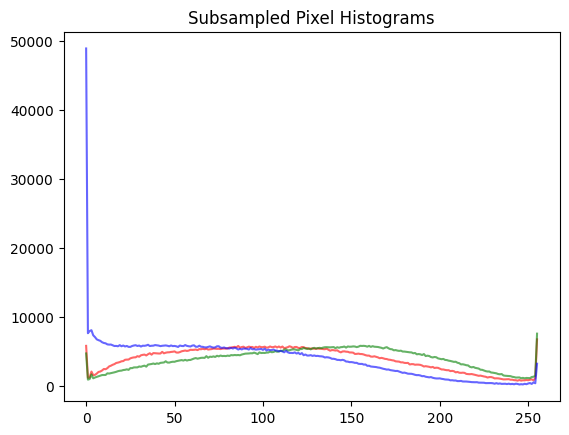

In [ ]:
# this function randomly samples up to 1,000 images and 1,000 pixels per image to build approximate R, G, B histograms.
# this gives a low‐compute estimate of the dataset’s color‐distribution

def subsampled_histogram(image_paths, sample_imgs=1000, samples_per_img=1000):
    picks = random.sample(image_paths, min(sample_imgs, len(image_paths)))
    hist = np.zeros((3,256), dtype=int)

    for p in picks:
        img = np.array(Image.open(p).convert("RGB"))
        H, W, _ = img.shape
        ys = np.random.randint(0, H, samples_per_img)
        xs = np.random.randint(0, W, samples_per_img)
        pix = img[ys, xs]
        for c in range(3):
            h, _ = np.histogram(pix[:,c], bins=256, range=(0,255))
            hist[c] += h

    colors = ['r','g','b']
    for c,col in enumerate(colors):
        plt.plot(hist[c], color=col, alpha=0.6)
    plt.title("Subsampled Pixel Histograms")
    plt.show()

subsampled_histogram(all_paths)

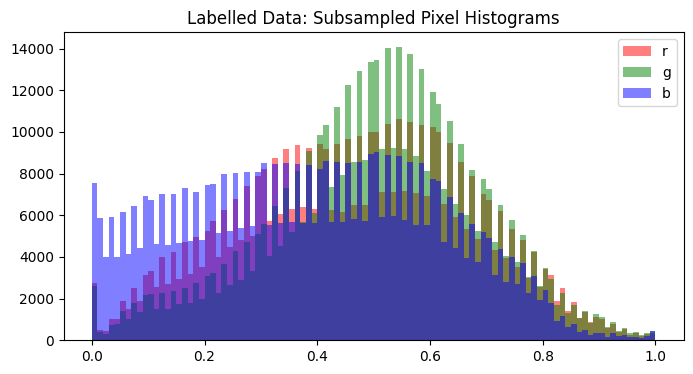

In [ ]:
# this function randomly samples up to 500 images and 1,000 pixels per image to build approximate R, G, B histograms for images in labelled dataset

def plot_pixel_histograms(loader, sample_images=500, samples_per_img=1000):
    all_pixels = []
    seen = 0
    for imgs, _ in loader:
        for img in imgs:
            pix = img.numpy().reshape(3, -1).T
            idx = np.random.choice(pix.shape[0], samples_per_img, replace=False)
            all_pixels.append(pix[idx])
            seen += 1
            if seen >= sample_images:
                break
        if seen >= sample_images:
            break
    all_pixels = np.vstack(all_pixels)

    colors = ['r','g','b']
    plt.figure(figsize=(8,4))
    for c,col in enumerate(colors):
        plt.hist(all_pixels[:,c], bins=100, color=col, alpha=0.5, label=col)
    plt.title("Labelled Data: Subsampled Pixel Histograms")
    plt.legend()
    plt.show()

plot_pixel_histograms(train_loader)

<ipython-input-15-1ff22a7e8cab>:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


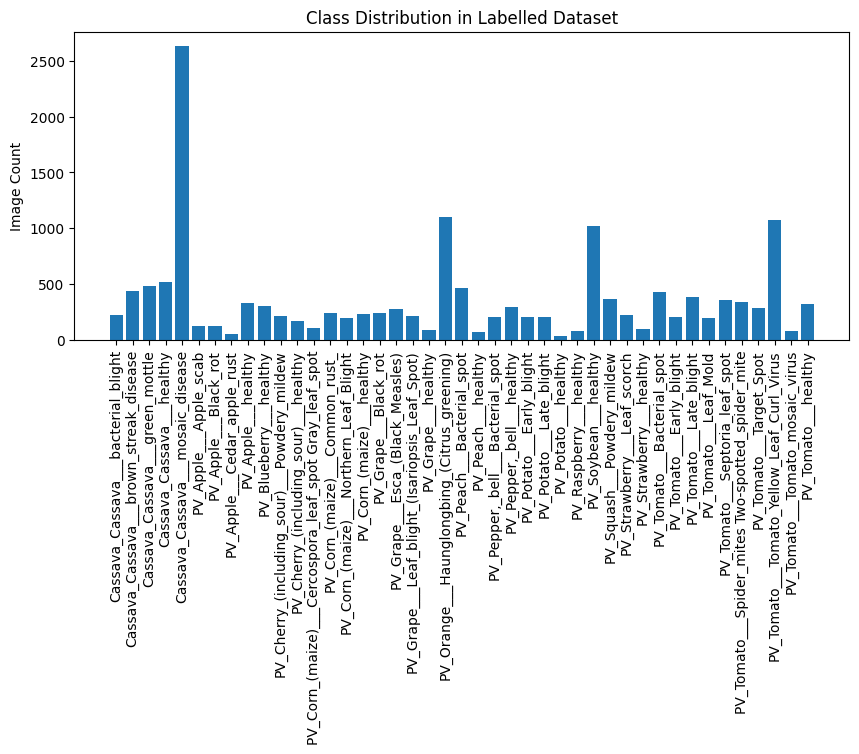

In [15]:
def plot_class_distribution(dataset):
    classes = dataset.classes
    counts  = [0]*len(classes)
    for _, label in dataset:
        counts[label] += 1

    plt.figure(figsize=(10,4))
    plt.bar(range(len(classes)), counts)
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.ylabel("Image Count")
    plt.title("Class Distribution in Labelled Dataset")
    plt.tight_layout()
    plt.show()

plot_class_distribution(labelled_dataset)

In [ ]:
# the function samples up to `max_samples` pairs of augmented views, pass them through the encoder of each model,
# and plot the cosine similarity distribution. This helps us quantify the invariance among the features in augmented data
# high similarity means strong invariance 

def sample_pair_similarity(name, dataset, encoder,device, max_samples=1000):
    encoder = encoder.to(device)
    encoder.eval()

    loader = DataLoader(dataset, batch_size=128, shuffle=True,
                        num_workers=4, pin_memory=True, drop_last=True)
    sims, seen = [], 0

    for v1, v2 in loader:
        v1, v2 = v1.to(device), v2.to(device)
        with torch.no_grad():
            f1 = F.normalize(encoder(v1), dim=1)
            f2 = F.normalize(encoder(v2), dim=1)
            cos = (f1 * f2).sum(dim=1).cpu().numpy()
        sims.extend(cos.tolist())
        seen += len(cos)
        if seen >= max_samples:
            break

    sims = np.array(sims[:max_samples])
    plt.figure(figsize=(6,4))
    plt.hist(sims, bins=50, color='skyblue', edgecolor='k')
    plt.title(f"{name} Positive‑Pair Cosine Similarities")
    plt.xlabel("Cosine Similarity"); plt.ylabel("Frequency")
    plt.show()
    print(f"{name} — Mean similarity over {len(sims)} samples: {sims.mean():.4f}")


In [ ]:
# this function plots all the normalized encoder features into 2D via t‑SNE. 
# Plotting view1 vs. view2 shows clusters for different augmentations of the same image

def visualize_embeddings(name, dataset, encoder,device, num_images=500):
    encoder = encoder.to(device)
    encoder.eval()

    idxs = np.random.choice(len(dataset), size=min(num_images, len(dataset)), replace=False)
    batch = [dataset[i] for i in idxs]
    v1s = torch.stack([v1 for v1,_ in batch], dim=0).to(device)
    v2s = torch.stack([v2 for _,v2 in batch], dim=0).to(device)

    with torch.no_grad():
        f1 = F.normalize(encoder(v1s), dim=1).cpu().numpy()
        f2 = F.normalize(encoder(v2s), dim=1).cpu().numpy()

    feats = np.vstack([f1, f2])
    emb2d = TSNE(n_components=2, init='pca', random_state=42).fit_transform(feats)
    
    plt.figure(figsize=(6,6))
    plt.scatter(emb2d[:len(f1),0], emb2d[:len(f1),1], c='C0', s=5, label='view1')
    plt.scatter(emb2d[len(f1):,0], emb2d[len(f1):,1], c='C1', s=5, label='view2')
    plt.title(f"{name} Embeddings via t‑SNE")
    plt.xlabel("t‑SNE Dim 1"); plt.ylabel("t‑SNE Dim 2")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [ ]:
# The same function as above but with a little helper function for BYOL and DINO encoders
# As BYOl and DINO may return a tuple/list of outputs;
# this ensures we extract the primary feature tensor before normalization.

def _run_encoder(encoder, x):
    out = encoder(x)
    if isinstance(out, (tuple, list)):
        out = out[0]
    return out

def sample_pair_similarity_ssl(name,image_folder,encoder,device,transform,max_samples: int = 1000):
    encoder = encoder.to(device).eval()
    paths = glob.glob(f"{image_folder}/*.jpg")
    sims = []
    for _ in range(max_samples):
        img = Image.open(random.choice(paths)).convert("RGB")
        v1 = transform(img).unsqueeze(0).to(device)
        v2 = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            f1 = F.normalize(_run_encoder(encoder, v1), dim=1)
            f2 = F.normalize(_run_encoder(encoder, v2), dim=1)
            sims.append((f1 * f2).sum().item())

    sims = np.array(sims)
    plt.figure(figsize=(6,4))
    plt.hist(sims, bins=50, edgecolor='k')
    plt.title(f"{name} Positive‑Pair Cosine Similarities")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()
    print(f"{name} — Mean similarity over {len(sims)} samples: {sims.mean():.4f}")

In [ ]:
def visualize_embeddings_ssl(name,image_folder,encoder,device,transform,num_images: int = 500):
    encoder = encoder.to(device).eval()
    paths = glob.glob(f"{image_folder}/*.jpg")
    sel = random.sample(paths, min(num_images, len(paths)))

    v1_list, v2_list = [], []
    for p in sel:
        img = Image.open(p).convert("RGB")
        v1_list.append(transform(img))
        v2_list.append(transform(img))

    v1s = torch.stack(v1_list).to(device)
    v2s = torch.stack(v2_list).to(device)

    with torch.no_grad():
        f1 = F.normalize(_run_encoder(encoder, v1s), dim=1).cpu().numpy()
        f2 = F.normalize(_run_encoder(encoder, v2s), dim=1).cpu().numpy()

    feats = np.vstack([f1, f2])

    emb2d = TSNE(n_components=2, init='pca', random_state=42).fit_transform(feats)

    plt.figure(figsize=(6,6))
    plt.scatter(emb2d[:len(f1),0], emb2d[:len(f1),1], s=5, label='view1')
    plt.scatter(emb2d[len(f1):,0], emb2d[len(f1):,1], s=5, label='view2')
    plt.title(f"{name} Embeddings via t‑SNE")
    plt.xlabel("t‑SNE Dim 1")
    plt.ylabel("t‑SNE Dim 2")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [ ]:
# function to plot loss curve for a single model

def plot_pretraining_loss(stats):
    epochs = stats["epoch"]
    losses = stats["loss"]

    plt.figure()
    plt.plot(epochs, losses, marker='o')
    plt.title("Pretraining Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [ ]:
# function to plot training time curve for a single model

def plot_training_times(stats):
    epochs = stats["epoch"]
    times = stats["time_s"]

    plt.figure()
    plt.plot(epochs, times, marker='o')
    plt.title("Time per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")
    plt.grid(True)
    plt.show()

In [ ]:
# function to plot loss and accuracy curve for a single model after finetuning

def plot_finetuning_curves(results):
    epochs = range(1, len(results["head_loss"]) + 1)

    # Loss curves
    plt.figure()
    plt.plot(epochs, results["head_loss"], marker='o', label="Head Loss")
    plt.plot(epochs, results["ft_loss"],   marker='o', label="FT Loss")
    plt.title("Finetuning Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy curves
    plt.figure()
    plt.plot(epochs, results["head_acc"], marker='o', label="Head Accuracy")
    plt.plot(epochs, results["ft_acc"],   marker='o', label="FT Accuracy")
    plt.title("Finetuning Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

## SimCLR
### * Model Creation
### * Pretraining (unlabelled data)
### * FineTuning (labelled data)
### * Results and Analysis

In [ ]:
# a lightweight PairwiseCosineLoss that encourages positive pairs to have high cosine similarity for SIMCLR
class PairwiseCosineLoss(nn.Module):
    def __init__(self, margin: float = 0.0):
        super().__init__()
        self.crit = nn.CosineEmbeddingLoss(margin=margin)

    def forward(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        labels = torch.ones(z1.size(0), device=z1.device)
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        loss = self.crit(z1, z2, labels)
        return loss

In [ ]:
# define SimCLR
backbone = resnet18(pretrained=False)
backbone.fc = nn.Identity()

model_simclr = nn.Sequential(backbone,SimCLRProjectionHead(512,512,64)).to(device)

criterion_simclr = PairwiseCosineLoss(margin=0.0)
opt_simclr = SGD(model_simclr.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)


print("SimCLR parameters:", sum(p.numel() for p in model_simclr.parameters()))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SimCLR parameters: 11472576


In [ ]:
## helper function to save checkpoints of model during pretraining and finetuning

def _save_checkpoint(model, optimizer, epoch, name, ckpt_dir):
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt = {
        'epoch':       epoch,
        'model_state': model.state_dict(),
        'opt_state':   optimizer.state_dict(),
    }
    path = os.path.join(ckpt_dir, f'{name.lower()}_ep{epoch:02d}.pth')
    torch.save(ckpt, path)
    print(f"   Saved checkpoint: {path}")

In [ ]:
# This function runs the SimCLR model through multiple epochs on unlabeled data using mixed‑precision:
# 1) For each batch, it encodes two augmented views, computes the cosine‑based contrastive loss, and updates via GradScaler.
# 2) It logs batch‑ and epoch‑level losses, records timing, and saves a checkpoint after each epoch for later resume or analysis.

def pretrain_simclr(model, optimizer, loss_fn, loader, device,start_epoch, end_epoch, ckpt_dir="ckpts", log_interval=50):
    scaler = GradScaler()
    stats = {"epoch": [], "loss": [], "time_s": []}

    for ep in range(start_epoch, end_epoch + 1):
        t0, running_loss = time.time(), 0.0
        model.train()
        print(f"\n=====[SimCLR] Starting epoch {ep}/{end_epoch}=====")

        for batch_idx, (x1, x2) in enumerate(loader, 1):
            x1, x2 = x1.to(device, non_blocking=True), x2.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                z1, z2 = model(x1), model(x2)
                loss = loss_fn(z1, z2)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                print(f"  • batch {batch_idx}/{len(loader)}  loss {loss.item():.4f}")

        avg_loss = running_loss / len(loader)
        elapsed = time.time() - t0
        print(f"=====[SimCLR] Epoch {ep} done  avg_loss {avg_loss:.4f}  time {elapsed:.1f}s=====")

        stats["epoch"].append(ep)
        stats["loss"].append(avg_loss)
        stats["time_s"].append(elapsed)
        _save_checkpoint(model, optimizer, ep, "SimCLR", ckpt_dir)

    return stats

In [ ]:
simCLR_stats = pretrain_simclr(model_simclr,opt_simclr,criterion_simclr,unlablled_loader,device,1,10,"ckpts/SimCLR")


=====[SimCLR] Starting epoch 1/10=====
  • batch 50/143  loss 0.0408
  • batch 100/143  loss 0.0181
=====[SimCLR] Epoch 1 done  avg_loss 0.0251  time 431.5s=====
   Saved checkpoint: /content/drive/MyDrive/ckpts/SimCLR/simclr_ep01.pth

=====[SimCLR] Starting epoch 2/10=====
  • batch 50/143  loss 0.0066
  • batch 100/143  loss 0.0042
=====[SimCLR] Epoch 2 done  avg_loss 0.0078  time 412.3s=====
   Saved checkpoint: /content/drive/MyDrive/ckpts/SimCLR/simclr_ep02.pth

=====[SimCLR] Starting epoch 3/10=====
  • batch 50/143  loss 0.0066
  • batch 100/143  loss 0.0022
=====[SimCLR] Epoch 3 done  avg_loss 0.0036  time 407.9s=====
   Saved checkpoint: /content/drive/MyDrive/ckpts/SimCLR/simclr_ep03.pth

=====[SimCLR] Starting epoch 4/10=====
  • batch 50/143  loss 0.0016
  • batch 100/143  loss 0.0011
=====[SimCLR] Epoch 4 done  avg_loss 0.0016  time 418.4s=====
   Saved checkpoint: /content/drive/MyDrive/ckpts/SimCLR/simclr_ep04.pth

=====[SimCLR] Starting epoch 5/10=====
  • batch 50/143

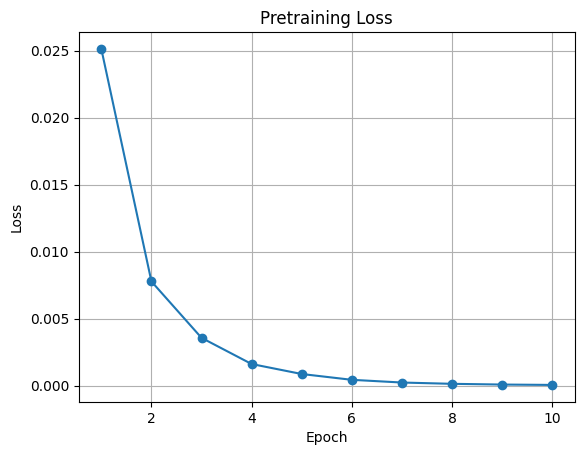

In [35]:
plot_pretraining_loss(simCLR_stats)

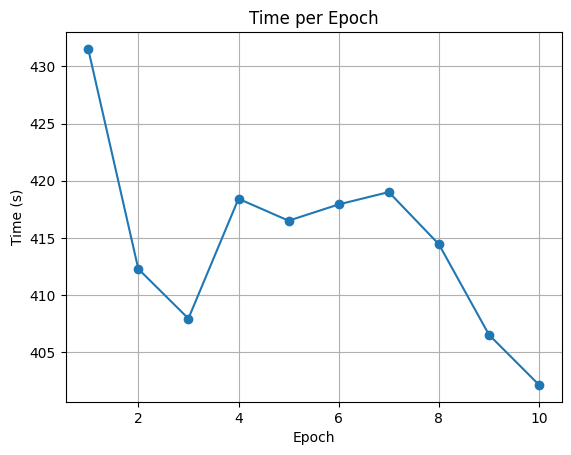

In [36]:
plot_training_times(simCLR_stats)

In [ ]:
# extract encoder for analysis
encoder_simclr = model_simclr[0]

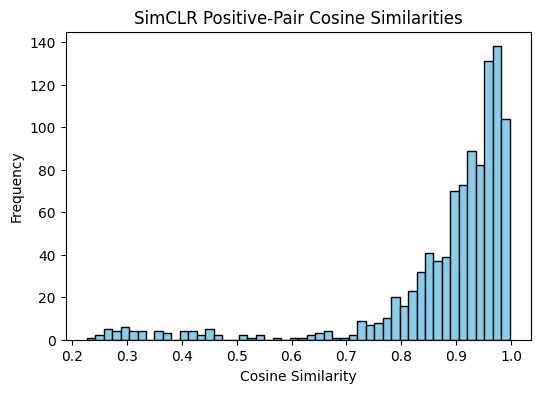

SimCLR — Mean similarity over 1000 samples: 0.8839


In [40]:
# Positive Pair Similarity - SimCLR
sample_pair_similarity('SimCLR',unlabelled_dataset,model_simclr, encoder_simclr, device)

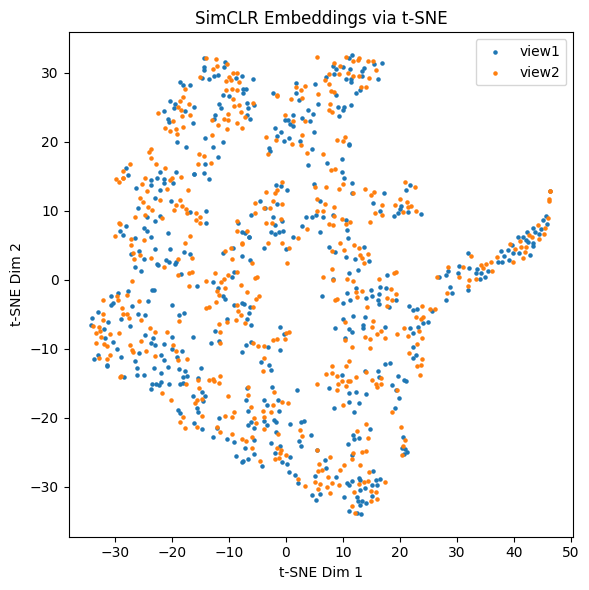

In [41]:
# Visualize embeddings - SimCLR
visualize_embeddings('SimCLR',unlabelled_dataset, model_simclr,encoder_simclr,device)

In [ ]:
# We first freeze the SSL “backbone” and train only a new linear classifier head to quickly adapt
# to the plant‑disease labels, then unfreeze the entire encoder for joint fine‑tuning to refine
# features end‑to‑end—logging loss & accuracy for both the head‐only and full‐model phases.

def finetune_SimCLR(ssl_model, encoder,labelled_loader,device,num_classes,head_epochs=10,ft_epochs=10,lr_head=1e-3,lr_ft=1e-4):
    print(f"\n=== Fine‑tuning SimCLR ===")
    ssl_model.eval()
    encoder = encoder.to(device)

    # 1) Attach classification head
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=device)
        feat_dim = encoder(dummy).shape[1]
    head = nn.Linear(feat_dim, num_classes).to(device)

    # prepare result containers
    results = {
        "head_loss": [], 
        "head_acc": [],
        "ft_loss":   [], 
        "ft_acc":  []
    }

    # Phase 1: train head only
    for param in encoder.parameters():
        param.requires_grad = False
    opt = Adam(head.parameters(), lr=lr_head)
    crit = nn.CrossEntropyLoss()

    for epoch in range(1, head_epochs+1):
        encoder.eval(); head.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        for imgs, labels in labelled_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats  = encoder(imgs)
            logits = head(feats)
            loss   = crit(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        avg_loss = total_loss / len(labelled_loader)
        preds    = torch.cat(all_preds)
        labs     = torch.cat(all_labels)
        acc      = accuracy_score(labs, preds)

        print(f"[SimCLR] Head‑Epoch {epoch}/{head_epochs}  Loss: {avg_loss:.4f}  Acc: {acc:.3f}")

        results["head_loss"].append(avg_loss)
        results["head_acc"].append(acc)

    # Phase 2: unfreeze encoder + joint train
    for param in encoder.parameters():
        param.requires_grad = True
    opt = Adam(list(encoder.parameters()) + list(head.parameters()), lr=lr_ft)

    for epoch in range(1, ft_epochs+1):
        encoder.train(); head.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        for imgs, labels in labelled_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats  = encoder(imgs)
            logits = head(feats)
            loss   = crit(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        avg_loss = total_loss / len(labelled_loader)
        preds    = torch.cat(all_preds)
        labs     = torch.cat(all_labels)
        acc      = accuracy_score(labs, preds)

        print(f"[SimCLR] FT‑Epoch {epoch}/{ft_epochs}  Loss: {avg_loss:.4f}  Acc: {acc:.3f}")

        results["ft_loss"].append(avg_loss)
        results["ft_acc"].append(acc)

    return results

In [20]:
simclr_finetune_results = finetune_SimCLR(model_simclr,encoder_simclr, train_loader, device,num_classes)


=== Fine‑tuning SimCLR ===
[SimCLR] Head‑Epoch 1/10  Loss: 3.3147  Acc: 0.169
[SimCLR] Head‑Epoch 2/10  Loss: 3.0960  Acc: 0.181
[SimCLR] Head‑Epoch 3/10  Loss: 2.9585  Acc: 0.248
[SimCLR] Head‑Epoch 4/10  Loss: 2.8485  Acc: 0.286
[SimCLR] Head‑Epoch 5/10  Loss: 2.7577  Acc: 0.306
[SimCLR] Head‑Epoch 6/10  Loss: 2.6827  Acc: 0.317
[SimCLR] Head‑Epoch 7/10  Loss: 2.6180  Acc: 0.333
[SimCLR] Head‑Epoch 8/10  Loss: 2.5635  Acc: 0.345
[SimCLR] Head‑Epoch 9/10  Loss: 2.5151  Acc: 0.355
[SimCLR] Head‑Epoch 10/10  Loss: 2.4735  Acc: 0.369
[SimCLR] FT‑Epoch 1/10  Loss: 1.9307  Acc: 0.499
[SimCLR] FT‑Epoch 2/10  Loss: 1.3261  Acc: 0.618
[SimCLR] FT‑Epoch 3/10  Loss: 1.0974  Acc: 0.668
[SimCLR] FT‑Epoch 4/10  Loss: 0.8971  Acc: 0.720
[SimCLR] FT‑Epoch 5/10  Loss: 0.7681  Acc: 0.756
[SimCLR] FT‑Epoch 6/10  Loss: 0.6551  Acc: 0.790
[SimCLR] FT‑Epoch 7/10  Loss: 0.5762  Acc: 0.810
[SimCLR] FT‑Epoch 8/10  Loss: 0.5287  Acc: 0.824
[SimCLR] FT‑Epoch 9/10  Loss: 0.4678  Acc: 0.843
[SimCLR] FT‑Epoch 10

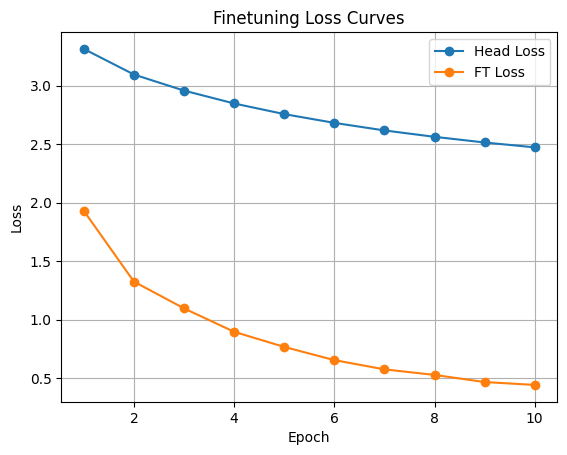

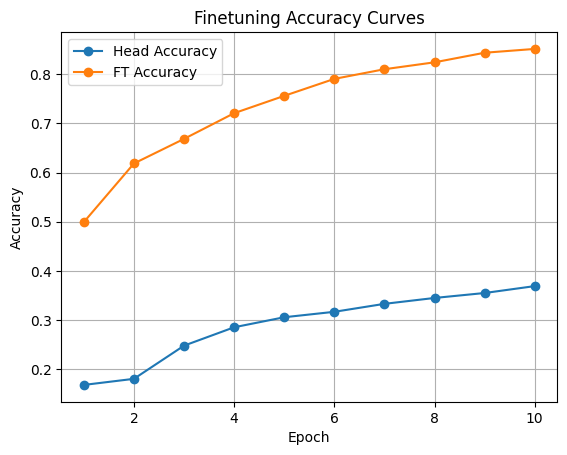

In [23]:
plot_finetuning_curves(simclr_finetune_results)

### MoCo
### * Model Creation
### * Pretraining (unlabelled data)
### * FineTuning (labelled data)
### * Results and Analysis

In [ ]:
# MoCo
batch_size = unlablled_loader.batch_size                       # e.g. 128
desired_K = 16384                                      # or whatever you want
K = (desired_K // batch_size) * batch_size
# 2.2 MoCo v2
model_moco   = MoCo(base_encoder=lambda **kwargs: resnet18(weights=None, **kwargs),dim=64,K=K,sizem=0.99,updateT=0.2)
print("MoCo parameters:", sum(p.numel() for p in model_moco.parameters()))

MoCo parameters: 22418688


In [26]:
opt_moco  = SGD(model_moco.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

In [ ]:
def pretrain_moco(model, optimizer, loader, device,start_epoch, end_epoch, ckpt_dir="ckpts", log_interval=50):
    stats = {"epoch": [], "loss": [], "time_s": []}

    for ep in range(start_epoch, end_epoch + 1):
        t0, running_loss = time.time(), 0.0
        model.train()
        print(f"\n[MoCo] Starting epoch {ep}/{end_epoch}")

        for batch_idx, (x1, x2) in enumerate(loader, 1):
            x1, x2 = x1.to(device), x2.to(device)
            optimizer.zero_grad()

            out = model(x1, x2)
            if isinstance(out, tuple):
                logits, labels = out
                loss = F.cross_entropy(logits, labels)
            else:
                loss = out

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                print(f"  • batch {batch_idx}/{len(loader)}  loss {loss.item():.4f}")

        avg_loss = running_loss / len(loader)
        elapsed = time.time() - t0
        print(f"[MoCo] Epoch {ep} done  avg_loss {avg_loss:.4f}  time {elapsed:.1f}s")

        stats["epoch"].append(ep)
        stats["loss"].append(avg_loss)
        stats["time_s"].append(elapsed)
        _save_checkpoint(model, optimizer, ep, "MoCo", ckpt_dir)

    return stats

In [ ]:
moco_stats = pretrain_moco(model_moco,opt_moco,unlablled_loader,device,1,10,"ckpts/MoCo")


[MoCo] Starting epoch 1/10
  • batch 50/143  loss 7.8271
  • batch 100/143  loss 7.4747
[MoCo] Epoch 1 done  avg_loss 7.4851  time 409.3s
   Saved checkpoint: /content/drive/MyDrive/ckpts/MoCo/moco_ep01.pth

[MoCo] Starting epoch 2/10
  • batch 50/143  loss 6.8146
  • batch 100/143  loss 6.8953
[MoCo] Epoch 2 done  avg_loss 6.8967  time 404.5s
   Saved checkpoint: /content/drive/MyDrive/ckpts/MoCo/moco_ep02.pth

[MoCo] Starting epoch 3/10
  • batch 50/143  loss 6.9585
  • batch 100/143  loss 6.9901
[MoCo] Epoch 3 done  avg_loss 6.9848  time 418.5s
   Saved checkpoint: /content/drive/MyDrive/ckpts/MoCo/moco_ep03.pth

[MoCo] Starting epoch 4/10
  • batch 50/143  loss 6.9490
  • batch 100/143  loss 7.0753
[MoCo] Epoch 4 done  avg_loss 7.0011  time 409.7s
   Saved checkpoint: /content/drive/MyDrive/ckpts/MoCo/moco_ep04.pth

[MoCo] Starting epoch 5/10
  • batch 50/143  loss 7.1376
  • batch 100/143  loss 7.0645
[MoCo] Epoch 5 done  avg_loss 7.0524  time 405.0s
   Saved checkpoint: /content

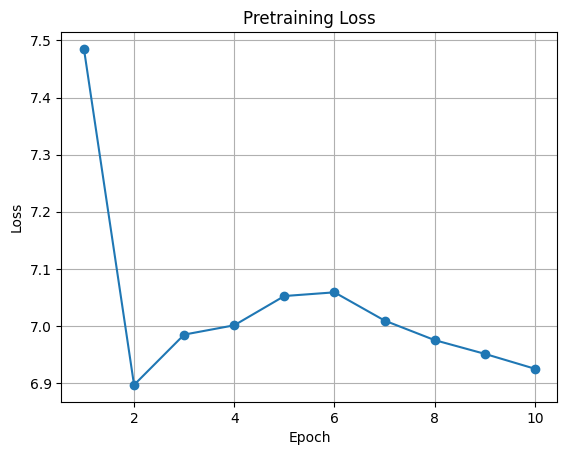

In [32]:
plot_pretraining_loss(moco_stats)

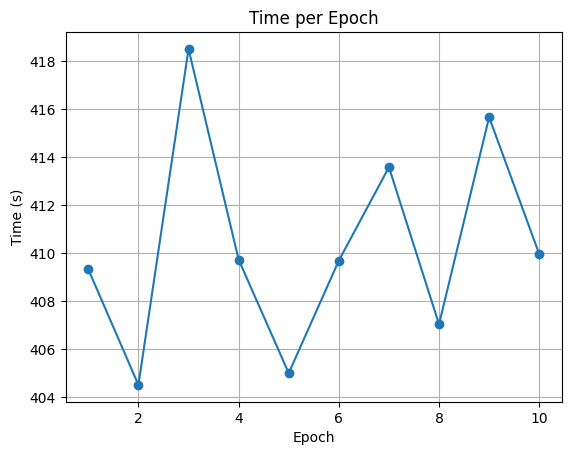

In [33]:
plot_training_times(moco_stats)

In [34]:
encoder_moco = model_moco.encoder_q

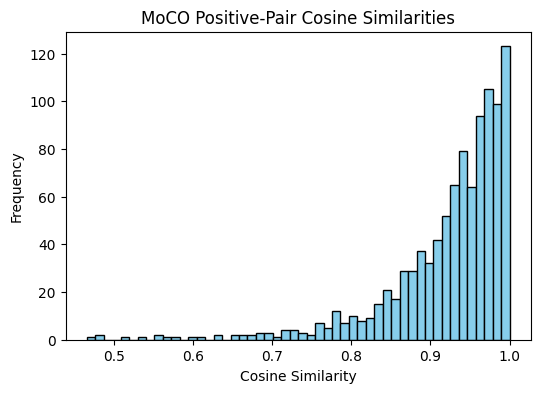

MoCO — Mean similarity over 1000 samples: 0.9228


In [37]:
sample_pair_similarity("MoCO",unlabelled_dataset,model_moco,encoder_moco, device)

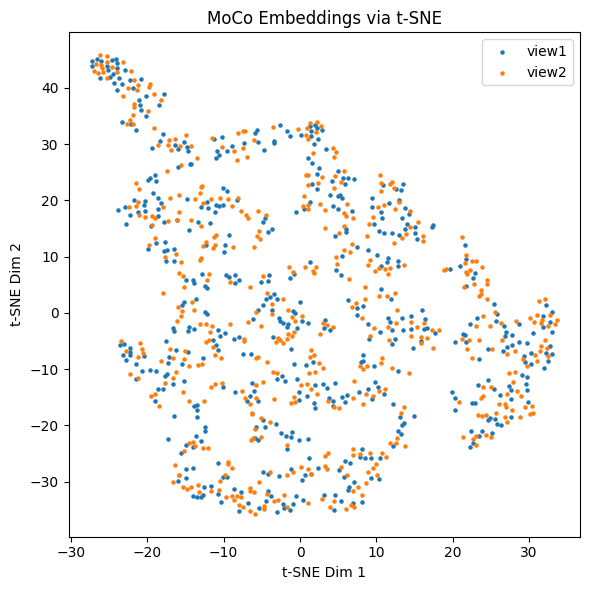

In [38]:
visualize_embeddings("MoCo",unlabelled_dataset,model_moco,encoder_moco,device)

In [ ]:
# Finetuning - SimCLR
def finetune_MoCo(ssl_model, encoder,labelled_loader,device,num_classes,head_epochs=10,ft_epochs=10,lr_head=1e-3,lr_ft=1e-4,):
    print(f"\n=== Fine‑tuning SimCLR ===")
    ssl_model.eval()
    encoder = encoder.to(device)

    # 1) Attach classification head
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=device)
        feat_dim = encoder(dummy).shape[1]
    head = nn.Linear(feat_dim, num_classes).to(device)

    # prepare result containers
    results = {
        "head_loss": [], "head_acc": [],
        "ft_loss":   [], "ft_acc":  []
    }

    # Phase 1: train head only
    for param in encoder.parameters():
        param.requires_grad = False
    opt = Adam(head.parameters(), lr=lr_head)
    crit = nn.CrossEntropyLoss()

    for epoch in range(1, head_epochs+1):
        encoder.eval(); head.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        for imgs, labels in labelled_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats  = encoder(imgs)
            logits = head(feats)
            loss   = crit(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        avg_loss = total_loss / len(labelled_loader)
        preds    = torch.cat(all_preds)
        labs     = torch.cat(all_labels)
        acc      = accuracy_score(labs, preds)

        print(f"[SimCLR] Head‑Epoch {epoch}/{head_epochs}  Loss: {avg_loss:.4f}  Acc: {acc:.3f}")

        results["head_loss"].append(avg_loss)
        results["head_acc"].append(acc)

    # Phase 2: unfreeze encoder + joint train
    for param in encoder.parameters():
        param.requires_grad = True
    opt = Adam(list(encoder.parameters()) + list(head.parameters()), lr=lr_ft)

    for epoch in range(1, ft_epochs+1):
        encoder.train(); head.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        for imgs, labels in labelled_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats  = encoder(imgs)
            logits = head(feats)
            loss   = crit(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        avg_loss = total_loss / len(labelled_loader)
        preds    = torch.cat(all_preds)
        labs     = torch.cat(all_labels)
        acc      = accuracy_score(labs, preds)

        print(f"[SimCLR] FT‑Epoch {epoch}/{ft_epochs}  Loss: {avg_loss:.4f}  Acc: {acc:.3f}")

        results["ft_loss"].append(avg_loss)
        results["ft_acc"].append(acc)

    return results

In [43]:
finetune_moco_results = finetune_MoCo(model_moco,encoder_moco,train_loader,device,num_classes)


=== Fine‑tuning SimCLR ===
[SimCLR] Head‑Epoch 1/10  Loss: 3.2494  Acc: 0.281
[SimCLR] Head‑Epoch 2/10  Loss: 2.4259  Acc: 0.350
[SimCLR] Head‑Epoch 3/10  Loss: 2.3536  Acc: 0.363
[SimCLR] Head‑Epoch 4/10  Loss: 2.3237  Acc: 0.372
[SimCLR] Head‑Epoch 5/10  Loss: 2.3022  Acc: 0.377
[SimCLR] Head‑Epoch 6/10  Loss: 2.2851  Acc: 0.379
[SimCLR] Head‑Epoch 7/10  Loss: 2.2762  Acc: 0.378
[SimCLR] Head‑Epoch 8/10  Loss: 2.2621  Acc: 0.388
[SimCLR] Head‑Epoch 9/10  Loss: 2.2523  Acc: 0.390
[SimCLR] Head‑Epoch 10/10  Loss: 2.2489  Acc: 0.392
[SimCLR] FT‑Epoch 1/10  Loss: 1.7215  Acc: 0.515
[SimCLR] FT‑Epoch 2/10  Loss: 1.1156  Acc: 0.670
[SimCLR] FT‑Epoch 3/10  Loss: 0.8398  Acc: 0.743
[SimCLR] FT‑Epoch 4/10  Loss: 0.6752  Acc: 0.791
[SimCLR] FT‑Epoch 5/10  Loss: 0.5302  Acc: 0.837
[SimCLR] FT‑Epoch 6/10  Loss: 0.4526  Acc: 0.859
[SimCLR] FT‑Epoch 7/10  Loss: 0.3839  Acc: 0.878
[SimCLR] FT‑Epoch 8/10  Loss: 0.3349  Acc: 0.894
[SimCLR] FT‑Epoch 9/10  Loss: 0.2938  Acc: 0.906
[SimCLR] FT‑Epoch 10

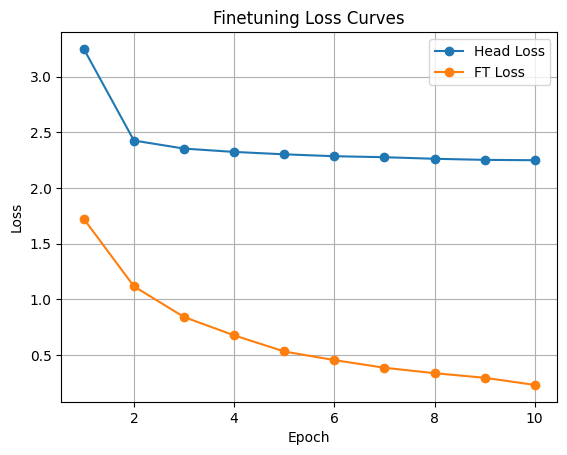

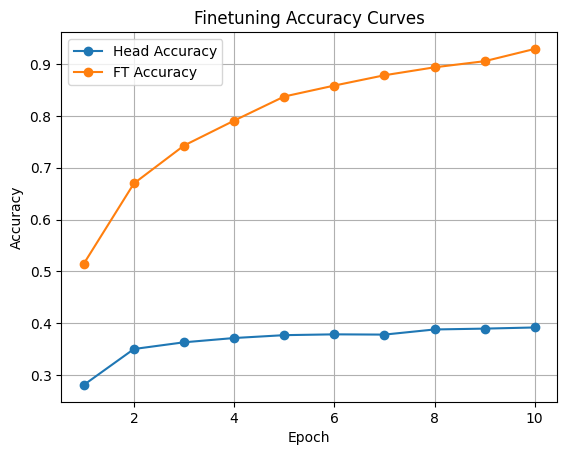

In [44]:
plot_finetuning_curves(finetune_moco_results)

### BYOL
### * Model Creation
### * Pretraining (unlabelled data)
### * FineTuning (labelled data)
### * Results and Analysis

In [ ]:
# 2.3 BYOL
encoder_byol = resnet18(pretrained=False)
model_byol   = BYOL(encoder_byol,image_size=224,hidden_layer='avgpool',projection_size=64,projection_hidden_size=512,moving_average_decay=0.99).to(device)


opt_byol  = Adam(model_byol.parameters(), lr=3e-4)
print("BYOL parameters:", sum(p.numel() for p in model_byol.parameters()))

BYOL parameters: 24039184


In [ ]:
def pretrain_byol(model, optimizer, loader, device,start_epoch, end_epoch, ckpt_dir="ckpts", log_interval=50):
    scaler = GradScaler()
    stats = {"epoch": [], "loss": [], "time_s": []}

    for ep in range(start_epoch, end_epoch + 1):
        t0, running_loss = time.time(), 0.0
        model.train()
        print(f"\n[BYOL] Starting epoch {ep}/{end_epoch}")

        for batch_idx,images in enumerate(loader, 1):
            images = images.to(device)
            optimizer.zero_grad()

            # byol_pytorch will split images internally & compute loss
            with torch.amp.autocast('cuda'):
                loss = model(images)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            model.update_moving_average()   # sync online → target

            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                print(f"  • batch {batch_idx}/{len(loader)}  loss {loss.item():.4f}")

        avg_loss = running_loss / len(loader)
        elapsed = time.time() - t0
        print(f"[BYOL] Epoch {ep} done  avg_loss {avg_loss:.4f}  time {elapsed:.1f}s")

        stats["epoch"].append(ep)
        stats["loss"].append(avg_loss)
        stats["time_s"].append(elapsed)
        _save_checkpoint(model, optimizer, ep, "BYOL", ckpt_dir)

    return stats

In [ ]:
byol_stats = pretrain_byol(model_byol,opt_byol, byol_loader,device, 1, 10, "ckpts/BYOL")


[BYOL] Starting epoch 1/10
  • batch 50/143  loss 1.8463
  • batch 100/143  loss 0.8672
[BYOL] Epoch 1 done  avg_loss 1.7581  time 29.9s
   Saved checkpoint: /content/drive/MyDrive/ckpts/BYOL/byol_ep01.pth

[BYOL] Starting epoch 2/10
  • batch 50/143  loss 0.8780
  • batch 100/143  loss 1.3645
[BYOL] Epoch 2 done  avg_loss 1.1376  time 28.0s
   Saved checkpoint: /content/drive/MyDrive/ckpts/BYOL/byol_ep02.pth

[BYOL] Starting epoch 3/10
  • batch 50/143  loss 1.1511
  • batch 100/143  loss 0.8573
[BYOL] Epoch 3 done  avg_loss 0.7693  time 29.5s
   Saved checkpoint: /content/drive/MyDrive/ckpts/BYOL/byol_ep03.pth

[BYOL] Starting epoch 4/10
  • batch 50/143  loss 3.5147
  • batch 100/143  loss 1.2013
[BYOL] Epoch 4 done  avg_loss 0.5852  time 28.0s
   Saved checkpoint: /content/drive/MyDrive/ckpts/BYOL/byol_ep04.pth

[BYOL] Starting epoch 5/10
  • batch 50/143  loss 0.2496
  • batch 100/143  loss 0.4042
[BYOL] Epoch 5 done  avg_loss 0.5662  time 27.7s
   Saved checkpoint: /content/driv

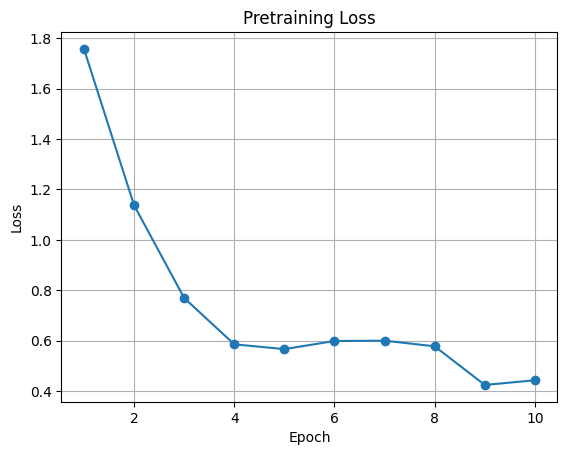

In [65]:
plot_pretraining_loss(byol_stats)

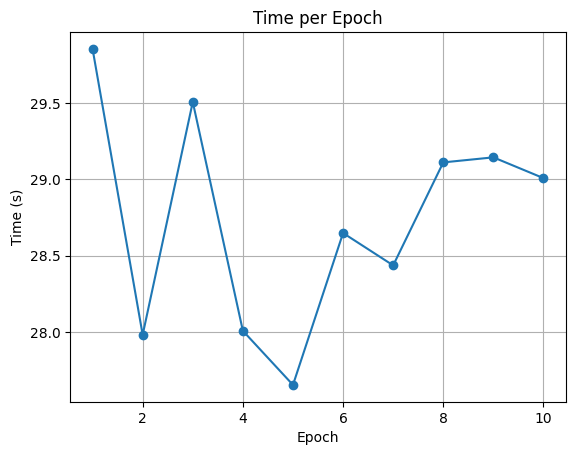

In [66]:
plot_training_times(byol_stats)

In [67]:
encoder_byol = model_byol.online_encoder

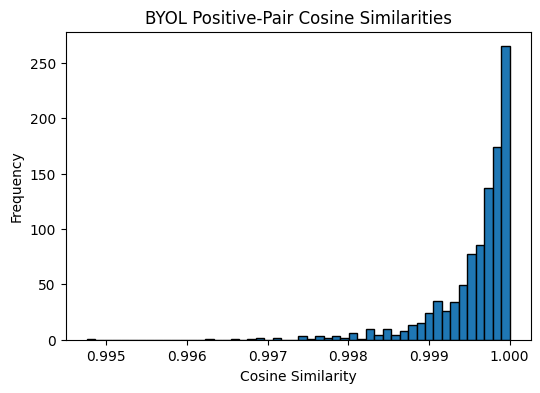

BYOL — Mean similarity over 1000 samples: 0.9996


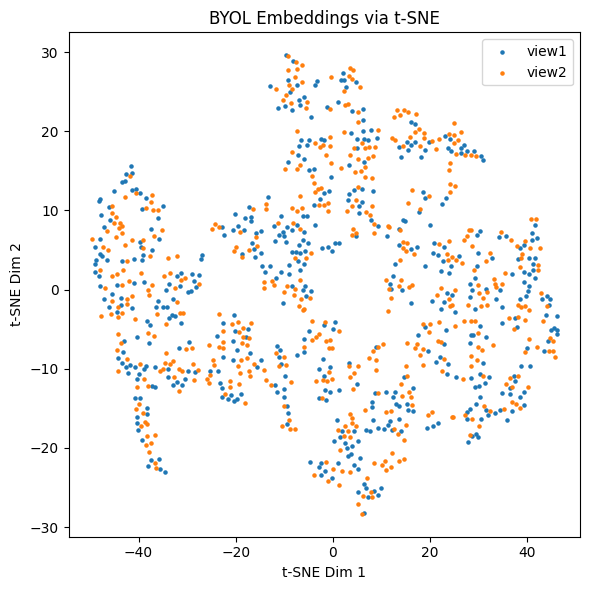

In [ ]:
sample_pair_similarity_ssl("BYOL", unlabeled_path, encoder_byol, device, ssl_transform, max_samples=1000)
visualize_embeddings_ssl("BYOL", unlabeled_path, encoder_byol, device, ssl_transform, num_images=500)

In [ ]:
def _unwrap(x):
    return x[0] if isinstance(x, (tuple, list)) else x

def finetune_byol(ssl_model,encoder,labelled_loader,device,num_classes,head_epochs=10,ft_epochs=10,lr_head=1e-3,lr_ft=1e-4):
    print(f"\n=== Fine‑tuning BYOL (num_classes={num_classes}) ===")
    ssl_model.eval()
    encoder = encoder.to(device)

    # 1) Infer the feature dim by running a dummy through the encoder
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=device)
        out = encoder(dummy)
        out = _unwrap(out)
        feat_dim = out.shape[1]

    # 2) Build the head
    head = nn.Linear(feat_dim, num_classes).to(device)
    crit = nn.CrossEntropyLoss()
    results = {"head_loss": [], "head_acc": [], "ft_loss": [], "ft_acc": []}

    # Train head only 
    for p in encoder.parameters():
        p.requires_grad = False
    opt = Adam(head.parameters(), lr=lr_head)

    for epoch in range(1, head_epochs + 1):
        encoder.eval()
        head.train()
        total_loss, all_preds, all_labels = 0.0, [], []

        for imgs, labels in labelled_loader:
            imgs   = imgs.to(device)
            labels = labels.to(device).long()

            feats  = _unwrap(encoder(imgs))
            logits = head(feats)
            loss   = crit(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            all_preds.append(logits.argmax(dim=1).cpu())
            all_labels.append(labels.cpu())

        avg_loss = total_loss / len(labelled_loader)
        preds    = torch.cat(all_preds)
        labs     = torch.cat(all_labels)
        acc      = accuracy_score(labs, preds)

        print(f"[BYOL Head] Epoch {epoch}/{head_epochs} — Loss: {avg_loss:.4f}, Acc: {acc:.3f}")
        results["head_loss"].append(avg_loss)
        results["head_acc"].append(acc)

    # Joint fine‑tune 
    for p in encoder.parameters():
        p.requires_grad = True
    opt = Adam(list(encoder.parameters()) + list(head.parameters()), lr=lr_ft)

    for epoch in range(1, ft_epochs + 1):
        encoder.train()
        head.train()
        total_loss, all_preds, all_labels = 0.0, [], []

        for imgs, labels in labelled_loader:
            imgs   = imgs.to(device)
            labels = labels.to(device).long()

            feats  = _unwrap(encoder(imgs))
            logits = head(feats)
            loss   = crit(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            all_preds.append(logits.argmax(dim=1).cpu())
            all_labels.append(labels.cpu())

        avg_loss = total_loss / len(labelled_loader)
        preds    = torch.cat(all_preds)
        labs     = torch.cat(all_labels)
        acc      = accuracy_score(labs, preds)

        print(f"[BYOL FT]   Epoch {epoch}/{ft_epochs} — Loss: {avg_loss:.4f}, Acc: {acc:.3f}")
        results["ft_loss"].append(avg_loss)
        results["ft_acc"].append(acc)

    return results

In [79]:
finetune_byol_results = finetune_byol(model_byol,encoder_byol,train_loader,device,num_classes)


=== Fine‑tuning BYOL (num_classes=43) ===
[BYOL Head] Epoch 1/10 — Loss: 3.4284, Acc: 0.139
[BYOL Head] Epoch 2/10 — Loss: 3.3348, Acc: 0.172
[BYOL Head] Epoch 3/10 — Loss: 3.3324, Acc: 0.172
[BYOL Head] Epoch 4/10 — Loss: 3.3310, Acc: 0.172
[BYOL Head] Epoch 5/10 — Loss: 3.3294, Acc: 0.172
[BYOL Head] Epoch 6/10 — Loss: 3.3275, Acc: 0.172
[BYOL Head] Epoch 7/10 — Loss: 3.3261, Acc: 0.172
[BYOL Head] Epoch 8/10 — Loss: 3.3242, Acc: 0.172
[BYOL Head] Epoch 9/10 — Loss: 3.3227, Acc: 0.172
[BYOL Head] Epoch 10/10 — Loss: 3.3209, Acc: 0.172
[BYOL FT]   Epoch 1/10 — Loss: 2.2808, Acc: 0.390
[BYOL FT]   Epoch 2/10 — Loss: 1.5512, Acc: 0.579
[BYOL FT]   Epoch 3/10 — Loss: 1.2004, Acc: 0.663
[BYOL FT]   Epoch 4/10 — Loss: 0.9669, Acc: 0.722
[BYOL FT]   Epoch 5/10 — Loss: 0.8026, Acc: 0.762
[BYOL FT]   Epoch 6/10 — Loss: 0.6655, Acc: 0.801
[BYOL FT]   Epoch 7/10 — Loss: 0.5813, Acc: 0.825
[BYOL FT]   Epoch 8/10 — Loss: 0.5091, Acc: 0.839
[BYOL FT]   Epoch 9/10 — Loss: 0.4470, Acc: 0.858
[BYOL 

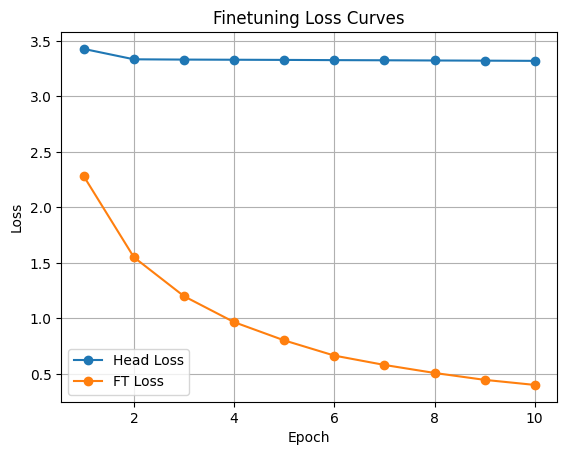

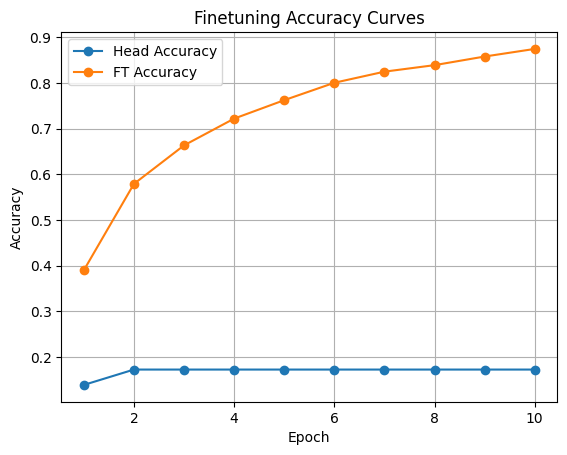

In [80]:
plot_finetuning_curves(finetune_byol_results)

### DINO
### * Model Creation
### * Pretraining (unlabelled data)
### * FineTuning (labelled data)
### * Results and Analysis

In [ ]:
# DINO works based on a student and teacher model 
# here we build DINO student & teacher networks with projection heads and optimizer
student_backbone = vit_small(patch_size=16)
teacher_backbone = vit_small(patch_size=16)


embed_dim = student_backbone.embed_dim  
student_head = DINOHead(in_dim=embed_dim, out_dim=65536, use_bn=False, nlayers=3)
teacher_head = DINOHead(in_dim=embed_dim, out_dim=65536, use_bn=False, nlayers=3)

model_student = MultiCropWrapper(student_backbone, student_head)
model_teacher = MultiCropWrapper(teacher_backbone, teacher_head)

for p in model_teacher.parameters():
    p.requires_grad = False

ncrops = 2 + 6

dino_loss_fn = DINOLoss(out_dim=65536, ncrops=ncrops, warmup_teacher_temp=0.04, teacher_temp=0.07, warmup_teacher_temp_epochs=10,nepochs=100,)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_student.to(device)
model_teacher.to(device)

params = list(model_student.parameters()) + list(model_teacher.parameters())

opt_dino = AdamW(params,lr=1e-4,weight_decay=0.04)

In [ ]:
# This function runs multi‐crop DINO training for the student/teacher pair: for each batch it computes 
# student & teacher projections on the global crops, applies the DINO loss, updates the student via AMP + GradScaler, 
# and momentum‐updates the teacher; it logs loss/time and saves checkpoints each epoch

def pretrain_dino(student_model,teacher_model,loss_fn,optimizer,loader,device,start_epoch: int,end_epoch: int,ckpt_dir: str = "ckpts/dino",log_interval: int = 50,teacher_momentum: float = 0.996):
    os.makedirs(ckpt_dir, exist_ok=True)
    scaler = GradScaler()
    stats = {"epoch": [], "loss": [], "time_s": []}

    student_model.train()
    teacher_model.eval()
    loss_fn = loss_fn.to(device)

    for epoch in range(start_epoch, end_epoch + 1):
        t0, running_loss = time.time(), 0.0
        print(f"\n[DINO] Epoch {epoch}/{end_epoch}")

        for batch_idx, crops in enumerate(loader, 1):
            crops = [c.to(device, non_blocking=True) for c in crops]
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                student_out = student_model(crops)
                with torch.no_grad():
                    teacher_out = teacher_model(crops[:2])
                loss = loss_fn(student_out, teacher_out, epoch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            for sp, tp in zip(student_model.parameters(), teacher_model.parameters()):
                tp.data.mul_(teacher_momentum).add_(sp.data, alpha=1 - teacher_momentum)

            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                print(f"  • batch {batch_idx}/{len(loader)}  loss {loss.item():.4f}")

        avg = running_loss / len(loader)
        elapsed = time.time() - t0
        print(f"[DINO] Epoch {epoch} done  avg_loss {avg:.4f}  time {elapsed:.1f}s")

        stats["epoch"].append(epoch)
        stats["loss"].append(avg)
        stats["time_s"].append(elapsed)

        ckpt = {
            "epoch":           epoch,
            "student_state":   student_model.state_dict(),
            "teacher_state":   teacher_model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
        }
        torch.save(ckpt, os.path.join(ckpt_dir, f"ep{epoch:02d}.pth"))

    return stats

In [ ]:
dino_stats = pretrain_dino(student_model  = model_student, teacher_model  = model_teacher, loss_fn= dino_loss_fn, optimizer= opt_dino, loader = dino_loader, device= device,
    start_epoch = 1, end_epoch = 10,ckpt_dir= "ckpts/DINO", log_interval = 50, teacher_momentum = 0.996)


[DINO] Epoch 1/10
  • batch 50/572  loss 10.7686
  • batch 100/572  loss 10.7033
  • batch 150/572  loss 10.6517
  • batch 200/572  loss 10.5603
  • batch 250/572  loss 10.4194
  • batch 300/572  loss 10.3144
  • batch 350/572  loss 10.5615
  • batch 400/572  loss 10.4157
  • batch 450/572  loss 10.2355
  • batch 500/572  loss 9.9312
  • batch 550/572  loss 9.8949
[DINO] Epoch 1 done  avg_loss 10.3963  time 129.9s

[DINO] Epoch 2/10
  • batch 50/572  loss 10.0379
  • batch 100/572  loss 9.9090
  • batch 150/572  loss 10.0896
  • batch 200/572  loss 10.0246
  • batch 250/572  loss 9.8125
  • batch 300/572  loss 9.9187
  • batch 350/572  loss 9.8007
  • batch 400/572  loss 9.6546
  • batch 450/572  loss 9.7226
  • batch 500/572  loss 9.7388
  • batch 550/572  loss 10.0691
[DINO] Epoch 2 done  avg_loss 9.9324  time 129.9s

[DINO] Epoch 3/10
  • batch 50/572  loss 9.5129
  • batch 100/572  loss 9.5928
  • batch 150/572  loss 9.8233
  • batch 200/572  loss 9.9006
  • batch 250/572  loss 9.

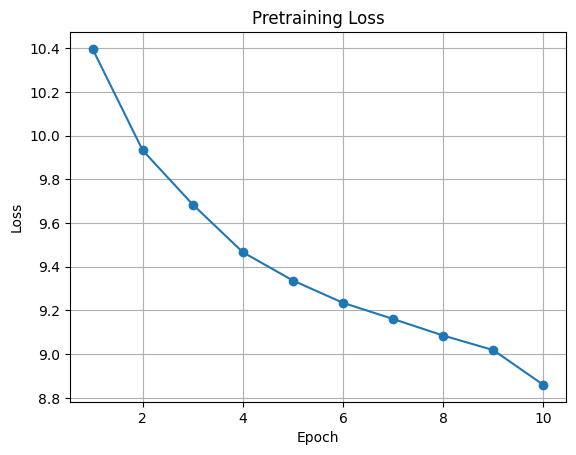

In [115]:
plot_pretraining_loss(dino_stats)

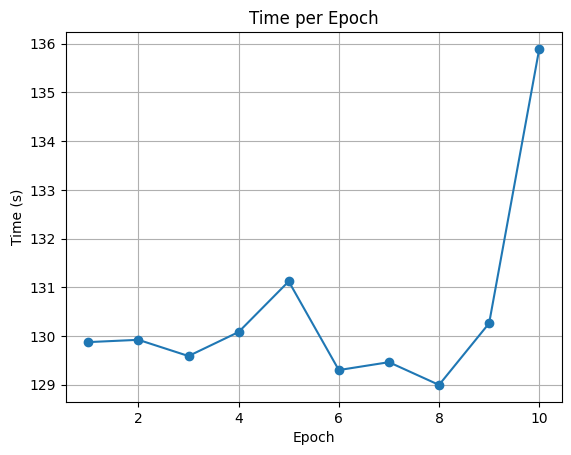

In [116]:
plot_training_times(dino_stats)

In [117]:
encoder_dino = student_backbone

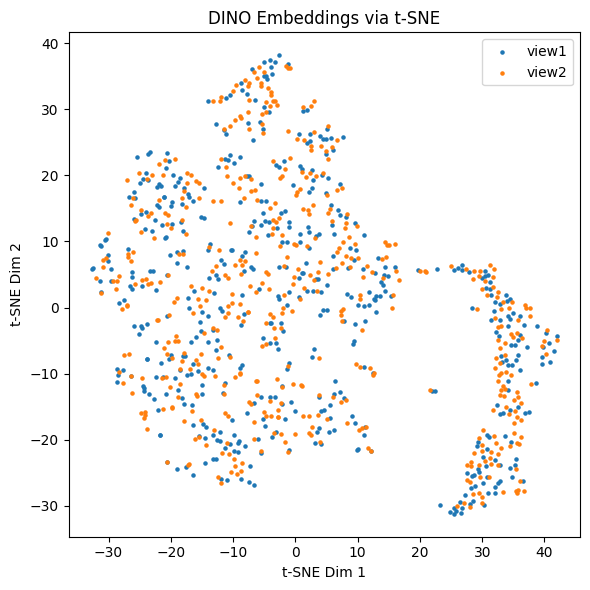

In [118]:
visualize_embeddings_ssl("DINO",unlabeled_path,encoder_dino,device,ssl_transform)

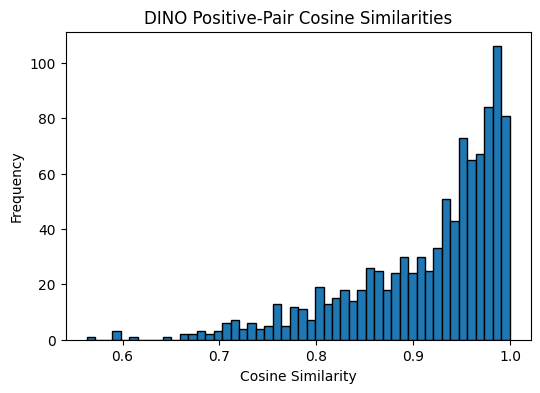

DINO — Mean similarity over 1000 samples: 0.9143


In [119]:
sample_pair_similarity_ssl("DINO",unlabeled_path,encoder_dino,device,ssl_transform)

In [ ]:
def finetune_dino(ssl_model, encoder, loader, device, num_classes,head_epochs=10, ft_epochs=10, lr_head=1e-3, lr_ft=1e-4):
    print(f"\n=== Fine‑tuning DINO (num_classes={num_classes}) ===")
    ssl_model.eval()
    encoder = encoder.to(device)

    # Build a new classification head
    with torch.no_grad():
        dummy = torch.randn(1,3,224,224,device=device)
        feat = _unwrap(encoder(dummy))
        feat_dim = feat.shape[1]
    head = nn.Linear(feat_dim, num_classes).to(device)

    crit = nn.CrossEntropyLoss()
    results = {"head_loss": [], "head_acc": [], "ft_loss": [], "ft_acc": []}

    #  train head only 
    for p in encoder.parameters(): p.requires_grad = False
    opt = Adam(head.parameters(), lr=lr_head)

    for epoch in range(1, head_epochs+1):
        encoder.eval(); head.train()
        total, preds_all, labs_all = 0.0, [], []
        for imgs, labs in loader:
            imgs = imgs.to(device); labs = labs.to(device).long()
            feats = _unwrap(encoder(imgs))
            logits = head(feats)
            loss = crit(logits, labs)

            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
            preds_all.append(logits.argmax(1).cpu())
            labs_all.append(labs.cpu())

        avg = total/len(loader)
        preds = torch.cat(preds_all); labs = torch.cat(labs_all)
        acc = accuracy_score(labs, preds)
        print(f"[DINO Head] Epoch {epoch}/{head_epochs} — Loss {avg:.4f}, Acc {acc:.3f}")
        results["head_loss"].append(avg); results["head_acc"].append(acc)

    #  joint fine‑tuning 
    for p in encoder.parameters(): p.requires_grad = True
    opt = Adam(list(encoder.parameters())+list(head.parameters()), lr=lr_ft)

    for epoch in range(1, ft_epochs+1):
        encoder.train(); head.train()
        total, preds_all, labs_all = 0.0, [], []
        for imgs, labs in loader:
            imgs = imgs.to(device); labs = labs.to(device).long()
            feats = _unwrap(encoder(imgs))
            logits = head(feats)
            loss = crit(logits, labs)

            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
            preds_all.append(logits.argmax(1).cpu())
            labs_all.append(labs.cpu())

        avg = total/len(loader)
        preds = torch.cat(preds_all); labs = torch.cat(labs_all)
        acc = accuracy_score(labs, preds)
        print(f"[DINO FT]   Epoch {epoch}/{ft_epochs} — Loss {avg:.4f}, Acc {acc:.3f}")
        results["ft_loss"].append(avg); results["ft_acc"].append(acc)

    return results

In [ ]:
dino_ft_stats = finetune_dino(ssl_model=model_student, encoder= encoder_dino, loader= train_loader, device= device, num_classes= num_classes,)


=== Fine‑tuning DINO (num_classes=43) ===
[DINO Head] Epoch 1/10 — Loss 2.8219, Acc 0.266
[DINO Head] Epoch 2/10 — Loss 2.2804, Acc 0.387
[DINO Head] Epoch 3/10 — Loss 2.0918, Acc 0.423
[DINO Head] Epoch 4/10 — Loss 1.9729, Acc 0.456
[DINO Head] Epoch 5/10 — Loss 1.8906, Acc 0.478
[DINO Head] Epoch 6/10 — Loss 1.8281, Acc 0.489
[DINO Head] Epoch 7/10 — Loss 1.7802, Acc 0.501
[DINO Head] Epoch 8/10 — Loss 1.7403, Acc 0.515
[DINO Head] Epoch 9/10 — Loss 1.7003, Acc 0.523
[DINO Head] Epoch 10/10 — Loss 1.6727, Acc 0.528
[DINO FT]   Epoch 1/10 — Loss 1.9224, Acc 0.485
[DINO FT]   Epoch 2/10 — Loss 1.2044, Acc 0.634
[DINO FT]   Epoch 3/10 — Loss 0.9900, Acc 0.689
[DINO FT]   Epoch 4/10 — Loss 0.8236, Acc 0.735
[DINO FT]   Epoch 5/10 — Loss 0.7171, Acc 0.767
[DINO FT]   Epoch 6/10 — Loss 0.6253, Acc 0.791
[DINO FT]   Epoch 7/10 — Loss 0.5726, Acc 0.804
[DINO FT]   Epoch 8/10 — Loss 0.5003, Acc 0.830
[DINO FT]   Epoch 9/10 — Loss 0.4460, Acc 0.849
[DINO FT]   Epoch 10/10 — Loss 0.3994, Acc 0

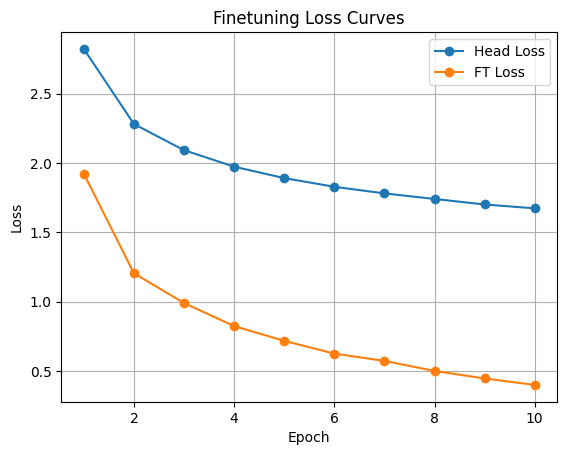

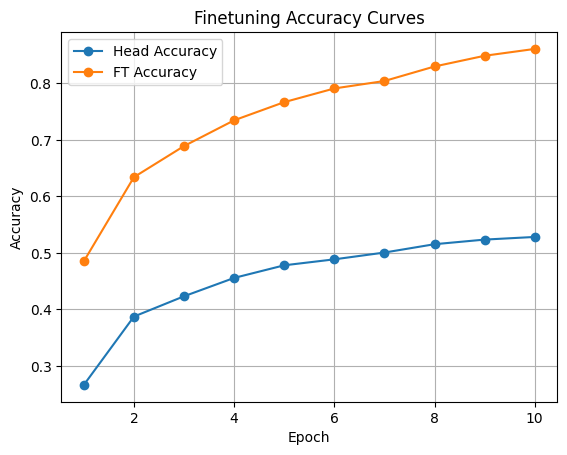

In [122]:
plot_finetuning_curves(dino_ft_stats)

In [ ]:
pretrain_stats = {"SimCLR": simCLR_stats,"MoCo":   moco_stats,"BYOL":   byol_stats,"DINO":   dino_stats,}

finetune_stats = {"SimCLR": simclr_finetune_results,"MoCo":   finetune_moco_results,"BYOL":   finetune_byol_results,"DINO":   dino_ft_stats,}

In [ ]:
def plot_all_model_metrics(pretrain_stats: dict, finetune_stats: dict):
    plt.figure()
    for name, stats in pretrain_stats.items():
        plt.plot(stats["epoch"], stats["loss"], marker='o', label=name)
    plt.title("Pretraining Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Head loss
    plt.figure()
    for name, stats in finetune_stats.items():
        plt.plot(range(1, len(stats["head_loss"]) + 1),
                 stats["head_loss"], marker='o', label=name)
    plt.title("Finetuning Head Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3) Head accuracy
    plt.figure()
    for name, stats in finetune_stats.items():
        plt.plot(range(1, len(stats["head_acc"]) + 1),
                 stats["head_acc"], marker='o', label=name)
    plt.title("Finetuning Head Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4) Fine‑tune (feat) loss
    plt.figure()
    for name, stats in finetune_stats.items():
        plt.plot(range(1, len(stats["ft_loss"]) + 1),
                 stats["ft_loss"], marker='o', label=name)
    plt.title("Finetuning Feature Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5) Fine‑tune (feat) accuracy
    plt.figure()
    for name, stats in finetune_stats.items():
        plt.plot(range(1, len(stats["ft_acc"]) + 1),
                 stats["ft_acc"], marker='o', label=name)
    plt.title("Finetuning Feature Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 6) Pretraining time per epoch
    plt.figure()
    for name, stats in pretrain_stats.items():
        plt.plot(stats["epoch"], stats["time_s"], marker='o', label=name)
    plt.title("Pretraining Time per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.grid(True)
    plt.show()

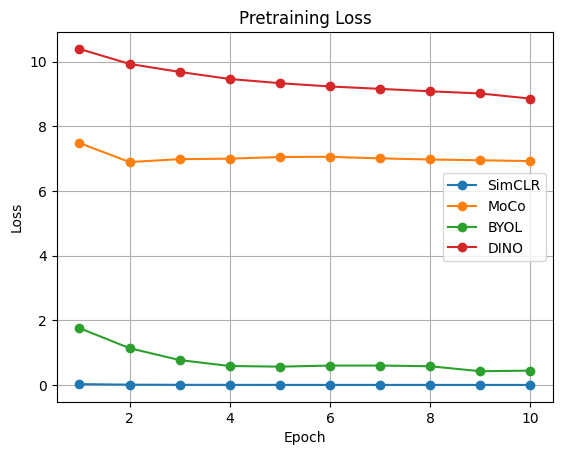

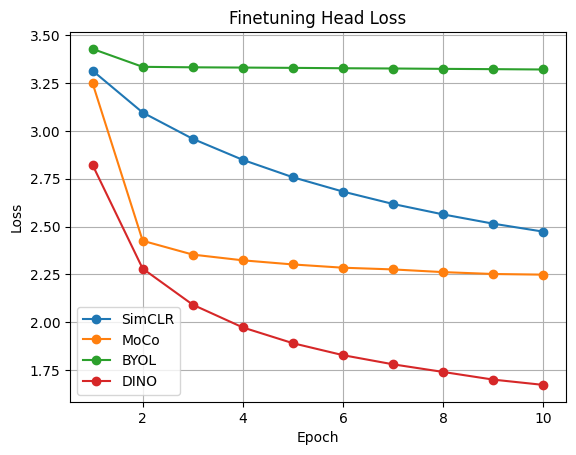

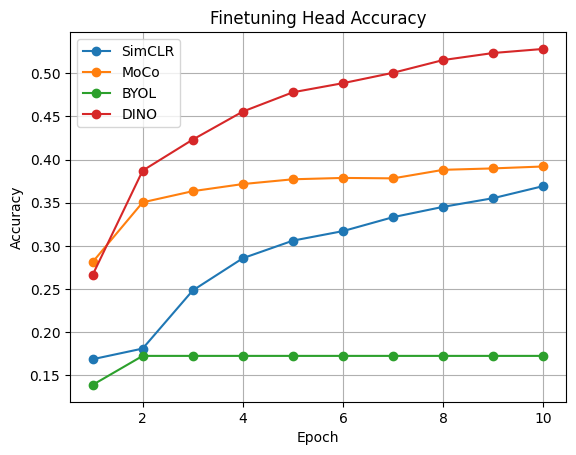

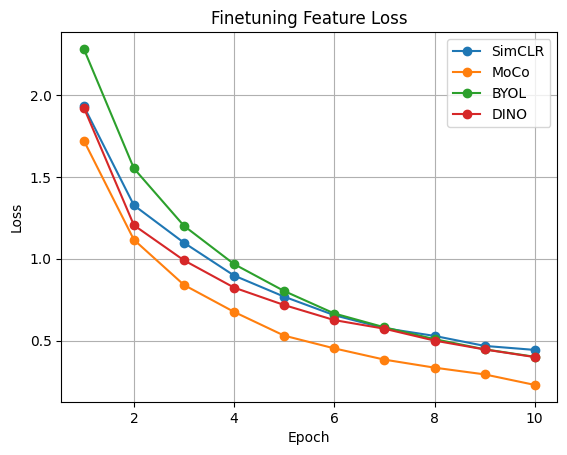

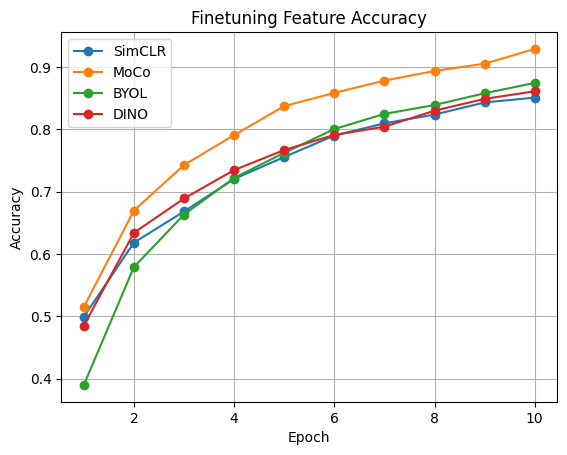

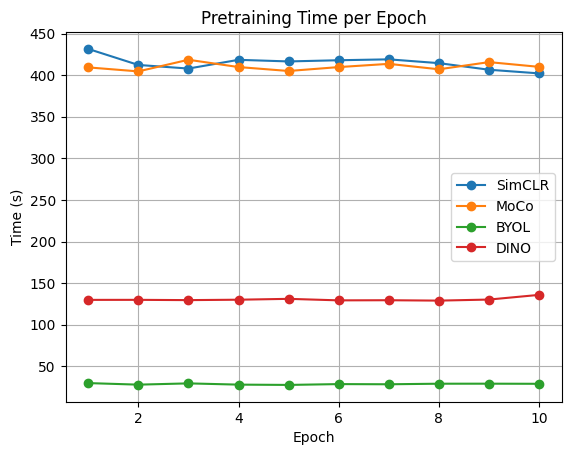

In [128]:
plot_all_model_metrics(pretrain_stats, finetune_stats)